In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
"""
returns percentage of authors and editors that are white as a dictionary
"""
def ethnicity_plot_each_year(author_data, editor_names, editor_ethnicities, year):
    authors = pd.read_csv(author_data).drop(labels=['Unnamed: 0', 'PaperTitle', 'OnlineDate', 'JournalId', 
                                                    'OriginalVenue', 'CreatedDate'], axis=1)
    editors = pd.read_csv(editor_names, names=["Editor", "Role", "x", "y", "z"])
    editor_eths = pd.read_csv(editor_ethnicities, names=["Editor", "Ethnicity", "Probability"])
    
    authors = authors[authors['Year'] == year]
    author_eth_percentage = -1
    if len(authors) > 0:
#         author_eths = authors[authors['Probability'] >= 0.90]
        author_eth_percentage = (authors['Ethnicity'].value_counts() / len(authors))
        if 'W_NL' in author_eth_percentage:
            author_eth_percentage = author_eth_percentage['W_NL']
        else:
            author_eth_percentage = 0

    editors = editors.join(editor_eths.set_index('Editor'), on=['Editor'], how='left')
    editor_eth_percentage = -1
    if len(editors) > 0:
#         editors = editors[editors['Probability'] >= 0.90]
        editor_eth_percentage = (editors['Ethnicity'].value_counts() / len(editors))
        if 'W_NL' in editor_eth_percentage:
            editor_eth_percentage = editor_eth_percentage['W_NL']
        else:
            editor_eth_percentage = 0
        
    return {"author": float( '%.3f'%(author_eth_percentage)), 
            "editor": float( '%.3f'%(editor_eth_percentage))}

In [4]:
"""
returns percentage of authors and editors that are white (in year buckets) as a dictionary
"""
def ethnicity_plot_buckets(author_data, editor_ethnicities, journal, start, end, magic):
    authors = pd.read_csv(author_data).drop(labels=['Unnamed: 0', 'PaperTitle', 'OnlineDate', 'JournalId', 
                                                    'OriginalVenue', 'CreatedDate'], axis=1)
    editor_eths = pd.read_csv(editor_ethnicities, names=["Editor", "Ethnicity", "Probability"])
    
    bucket_authors = pd.DataFrame()
    for i in range(start, end+1):
        bucket_authors = pd.concat([bucket_authors, authors[authors['Year'] == i]])
    author_eth_percentage = -1
    if len(bucket_authors) > 0:
#         author_eths = bucket_authors[bucket_authors['GenderProbability'] >= 0.90]
        author_eth_percentage = (bucket_authors['Ethnicity'].value_counts() / len(bucket_authors))
        if 'W_NL' in author_eth_percentage:
            author_eth_percentage = author_eth_percentage['W_NL']
        else:
            author_eth_percentage = 0
            
    bucket_editors = pd.DataFrame()
    for j in range(start, end+1):
        k = j - magic
        editors = pd.read_csv(f"../editor_data/extracted_names/{journal}/{journal}.{k}.extracted.txt", 
                              names=["Editor", "Role", "x", "y", "z"])
        editors = editors.join(editor_eths.set_index('Editor'), on=['Editor'], how='left')
        bucket_editors = pd.concat([bucket_editors, editors])
    editor_eth_percentage = -1
    if len(bucket_editors) > 0:
#         bucket_editors = bucket_editors[bucket_editors['Probability'] >= 0.90]
        editor_eth_percentage = (bucket_editors['Ethnicity'].value_counts() / len(bucket_editors))
        if 'W_NL' in editor_eth_percentage:
            editor_eth_percentage = editor_eth_percentage['W_NL']
        else:
            editor_eth_percentage = 0
    
    return {"author": float( '%.3f'%(author_eth_percentage)), 
            "editor": float( '%.3f'%(editor_eth_percentage))}

In [5]:
"""
gets aggregate results across all available years for a journal
"""
def call_ethnicity_plot_year(journal, start, end, magic):
    aggregate = {}
    for i in range(start, end+1):
        res = ethnicity_plot_each_year(f"../author_data/ethnicity/{journal}_authors_ethnicity.csv", 
                                    f"../editor_data/extracted_names/{journal}/{journal}.{i}.extracted.txt", 
                                    f"../editor_data/analysis/ethnicity/{journal}_editors_ethnicity.csv", 
                                    magic+i)
        aggregate[magic+i] = res
    return aggregate

In [6]:
def call_ethnicity_plot_bucket(journal, start, end, magic):
    aggregate = {}
    cutoff = start + 4
    
    while cutoff <= end:
        res = ethnicity_plot_buckets(f"../author_data/ethnicity/{journal}_authors_ethnicity.csv",
                                  f"../editor_data/analysis/ethnicity/{journal}_editors_ethnicity.csv",
                                  journal, start, cutoff, magic)
        aggregate[f"{start}-{cutoff}"] = res
        start += 5
        cutoff += 5

    if start <= end:
        res = ethnicity_plot_buckets(f"../author_data/ethnicity/{journal}_authors_ethnicity.csv",
                                  f"../editor_data/analysis/ethnicity/{journal}_editors_ethnicity.csv",
                                  journal, start, end, magic)
        aggregate[f"{start}-{end}"] = res
    return aggregate

In [7]:
aer_eth = call_ethnicity_plot_year("aer", 84, 113, 1910)
eco_eth  = call_ethnicity_plot_year("eco", 75, 91, 1932)
jpe_eth  = call_ethnicity_plot_year("jpe", 125, 131, 1892)
qje_eth  = call_ethnicity_plot_year("qje", 109, 138, 1885)
res_eth = call_ethnicity_plot_year("res", 61, 90, 1933)

In [8]:
aer_buckets = call_ethnicity_plot_bucket("aer", 1994, 2023, 1910)
eco_buckets = call_ethnicity_plot_bucket("eco", 2007, 2023, 1932)
jpe_buckets = call_ethnicity_plot_bucket("jpe", 2017, 2023, 1892)
qje_buckets = call_ethnicity_plot_bucket("qje", 1994, 2023, 1885)
res_buckets = call_ethnicity_plot_bucket("res", 1994, 2023, 1933)

In [9]:
def plot_ethnicity(journal, data):
    years = sorted(data.keys())
    authors = []
    editors = []
    for year in years:
        if data[year]['author'] == -1:
            authors.append(0)
        else:
            authors.append(1-data[year]['author'])
        if data[year]['editor'] == -1:
            editors.append(0)
        else:
            editors.append(1-data[year]['editor'])
    
    axes = plt.axes()
    axes.set_ylim([0, 1])
    plt.plot(years, authors, label='authors')
    plt.plot(years, editors, label='editors')
    plt.title(f'Percentage of Non-White Contributors at {journal.upper()}')
    plt.xticks(years, rotation=90)
    plt.legend()
    plt.show()

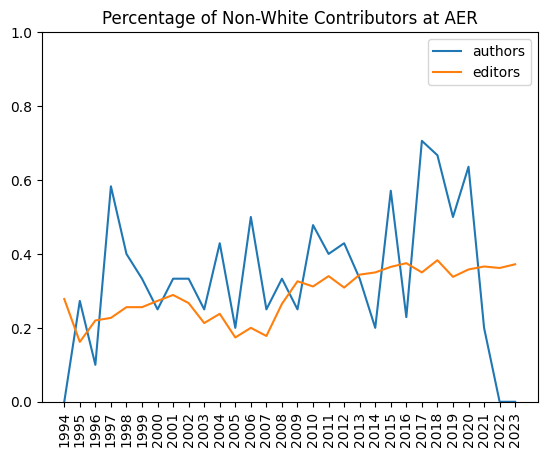

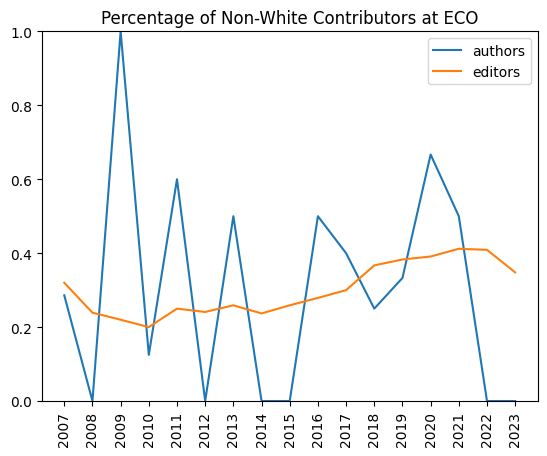

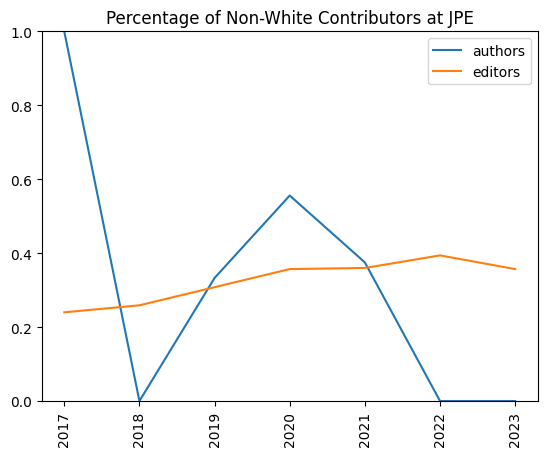

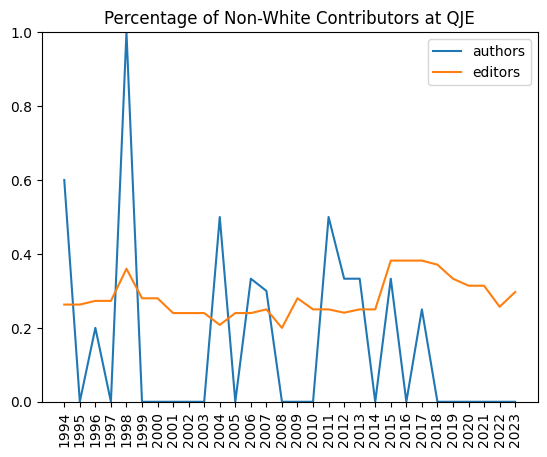

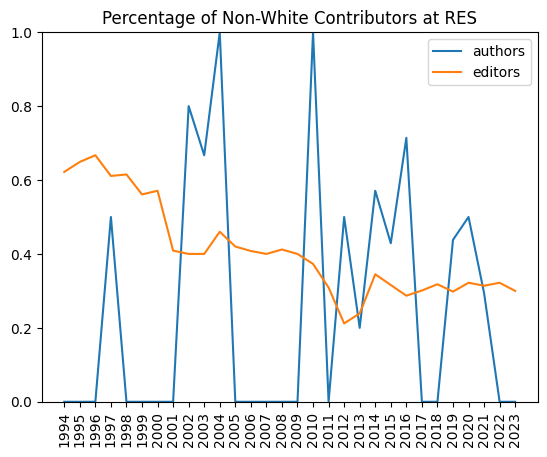

In [10]:
"""
yearly
"""
plot_ethnicity("aer", aer_eth)
plot_ethnicity("eco", eco_eth)
plot_ethnicity("jpe", jpe_eth)
plot_ethnicity("qje", qje_eth)
plot_ethnicity("res", res_eth)

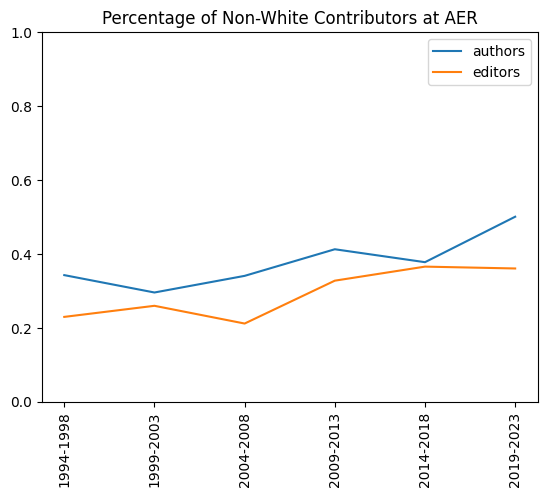

In [11]:
"""
bucketized
"""
plot_ethnicity("aer", aer_buckets)
# plot_ethnicity("eco", eco_buckets)
# plot_ethnicity("jpe", jpe_buckets)
# plot_ethnicity("qje", qje_buckets)
# plot_ethnicity("res", res_buckets)